Dataset : https://drive.google.com/drive/folders/1ZDVv9fsCaD3FdCp8RaoKKGFPfvmWbayd?usp=drive_link



This methodology applies CLAHE and color thresholding for image preprocessing, extracts features using DenseNet201, and trains a stacking ensemble classifier (Random Forest, Decision Tree, SVM) with Logistic Regression as the meta-model for multi-class classification.

In [1]:
import os
import numpy as np
import cv2
import timm
from tensorflow.keras.applications import DenseNet201, InceptionV3, Xception, ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import torch
from torch.nn.functional import adaptive_avg_pool2d
import tensorflow as tf


In [51]:

# Paths
data_dir = "./D3_Final"

# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-6
PATIENCE = 2
FACTOR = 0.5
MONITOR = "val_loss"
SAVE_BEST_ONLY = True
MODE = "min"
OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
LOSS = "categorical_crossentropy"

# CLAHE Preprocessing
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

# Fonction pour appliquer color thresholding
def remove_background_color_thresholding(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([35, 50, 50])  # Lower bound for green in HSV
    upper_green = np.array([85, 255, 255])  # Upper bound for green in HSV
    mask = cv2.inRange(hsv, lower_green, upper_green)
    mask_inv = cv2.bitwise_not(mask)
    result = cv2.bitwise_and(image, image, mask=mask_inv)
    return result
    
# Load and preprocess dataset
def load_data(data_dir, apply_clahe_flag=False,apply_color_thresholding=False):
    original_images, preprocessed_images, labels = [], [], []
    for label, class_dir in enumerate(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, class_dir)
        if not os.path.isdir(class_path):  # Ignore non-directory files
            continue
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:  # Check if the image was read correctly
                print(f"Warning: Unable to read image {img_path}. Skipping...")
                continue
            
            # Resize the original image
            img_resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_CUBIC)
            original_images.append(img_resized / 255.0)  # Normalization
            
            # Preprocess the image (CLAHE and color thresholding)
            preprocessed_img = img_resized.copy()
            if apply_color_thresholding:
                preprocessed_img = remove_background_color_thresholding(preprocessed_img)
            if apply_clahe_flag:
                preprocessed_img = apply_clahe(preprocessed_img)
            preprocessed_images.append(preprocessed_img / 255.0)  # Normalization
            
            labels.append(label)
    return np.array(original_images), np.array(preprocessed_images), np.array(labels)
    

In [88]:
# Load data
X_original, X_clahe, y = load_data(data_dir, apply_clahe_flag=True, apply_color_thresholding=True)

In [89]:
# Combine original and CLAHE datasets
X_combined = np.concatenate([X_original, X_clahe], axis=0)
y_combined = np.concatenate([y, y], axis=0)

In [90]:
# One-hot encode labels
y_combined = to_categorical(y_combined)

In [91]:
# Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [92]:

# Define feature extraction models
def create_model(base_model, input_shape):
    base = base_model(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
    x = GlobalAveragePooling2D()(base.output)
    return Model(inputs=base.input, outputs=x)

In [93]:
input_shape = (224, 224, 3)
model_DenseNet201 = create_model(DenseNet201, input_shape)
#model_InceptionV3 = create_model(InceptionV3, input_shape)
#model_Xception = create_model(Xception, input_shape)
#model_ResNet50V2 = create_model(ResNet50V2, input_shape)

In [94]:

# Feature extraction in batches
def extract_features_in_batches(model, data, batch_size=32):
    features = []
    for start in range(0, len(data), batch_size):
        end = start + batch_size
        batch_data = data[start:end]
        batch_tensor = tf.convert_to_tensor(batch_data, dtype=tf.float32)
        batch_features = model.predict(batch_tensor)  # Updated to use .predict()
        features.append(batch_features)
    return np.vstack(features)


In [95]:

# Extract features for training
features_DenseNet201 = extract_features_in_batches(model_DenseNet201, X_train, batch_size=BATCH_SIZE)
#features_InceptionV3 = extract_features_in_batches(model_InceptionV3, X_train, batch_size=BATCH_SIZE)
#features_Xception = extract_features_in_batches(model_Xception, X_train, batch_size=BATCH_SIZE)
#features_ResNet50V2 = extract_features_in_batches(model_ResNet50V2, X_train, batch_size=BATCH_SIZE)

D:\anaconda\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2124']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3

In [96]:

# Combine extracted features
#X_train_features = np.concatenate([features_DenseNet201, features_InceptionV3, features_Xception, features_ResNet50V2], axis=1)

X_train_features = np.concatenate([features_DenseNet201], axis=1)

In [97]:

# Extract features for validation
features_DenseNet201_val = extract_features_in_batches(model_DenseNet201, X_val, batch_size=BATCH_SIZE)
#features_InceptionV3_val = extract_features_in_batches(model_InceptionV3, X_val, batch_size=BATCH_SIZE)
#features_Xception_val = extract_features_in_batches(model_Xception, X_val, batch_size=BATCH_SIZE)
#features_ResNet50V2_val = extract_features_in_batches(model_ResNet50V2, X_val, batch_size=BATCH_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


D:\anaconda\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2124']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


In [98]:
#X_val_features = np.concatenate([features_DenseNet201_val, features_InceptionV3_val, features_Xception_val, features_ResNet50V2_val], axis=1)

X_val_features = np.concatenate([features_DenseNet201_val], axis=1)

In [99]:

# Extract features for testing
features_DenseNet201_test = extract_features_in_batches(model_DenseNet201, X_test, batch_size=BATCH_SIZE)
#features_InceptionV3_test = extract_features_in_batches(model_InceptionV3, X_test, batch_size=BATCH_SIZE)
#features_Xception_test = extract_features_in_batches(model_Xception, X_test, batch_size=BATCH_SIZE)
#features_ResNet50V2_test = extract_features_in_batches(model_ResNet50V2, X_test, batch_size=BATCH_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [100]:
#X_test_features = np.concatenate([features_DenseNet201_test, features_InceptionV3_test, features_Xception_test, features_ResNet50V2_test], axis=1) 

X_test_features = np.concatenate([features_DenseNet201_test], axis=1) 

In [101]:
# Ensemble learning
rf = RandomForestClassifier(n_estimators=50, max_features="log2", class_weight="balanced", random_state=1, min_samples_leaf=2, min_samples_split=5, bootstrap=True, criterion="gini", oob_score=True)
dt = DecisionTreeClassifier(max_depth=200, class_weight="balanced", random_state=0, min_samples_leaf=1, min_samples_split=2, criterion="gini", splitter="best", ccp_alpha=0.2, min_impurity_decrease=0.2)
svm = SVC(kernel="rbf", C=10, gamma=0.0001, class_weight="balanced", probability=True, tol=0.001, cache_size=256, max_iter=-1, decision_function_shape="ovr", break_ties=True)
ensemble_model = VotingClassifier(estimators=[("RF", rf), ("DT", dt), ("SVM", svm)], voting="hard", weights=[1, 2, 3], n_jobs=-1, verbose=2, flatten_transform=True)

In [66]:
# Train ensemble model
ensemble_model.fit(X_train_features, np.argmax(y_train, axis=1))

VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_features='log2',
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=50,
                                                     oob_score=True,
                                                     random_state=1)),
                             ('DT',
                              DecisionTreeClassifier(ccp_alpha=0.2,
                                                     class_weight='balanced',
                                                     max_depth=200,
                                                     min_impurity_decrease=0.2,
                                                     random_state=0)),
                             ('SVM',
                              SVC(C=10, break_ties=True, cache_size=256,
                                  class_weight='balanced', gamma=0.0001,
                                  probability=True))],
                 n_jobs=-1, verbose=2, weights=[1, 2, 3])

In [102]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base models
rf = RandomForestClassifier(n_estimators=50, max_features="log2", class_weight="balanced", random_state=1, min_samples_leaf=2, min_samples_split=5, bootstrap=True, criterion="gini", oob_score=True)
dt = DecisionTreeClassifier(max_depth=200, class_weight="balanced", random_state=0, min_samples_leaf=1, min_samples_split=2, criterion="gini", splitter="best", ccp_alpha=0.2, min_impurity_decrease=0.2)
svm = SVC(kernel="rbf", C=10, gamma=0.0001, class_weight="balanced", probability=True, tol=0.001, cache_size=256, max_iter=-1, decision_function_shape="ovr", break_ties=True)

# Define meta-model (e.g., Logistic Regression)
meta_model = LogisticRegression()

# Create the stacking ensemble
stacking_model = StackingClassifier(
    estimators=[("RF", rf), ("DT", dt), ("SVM", svm)],
    final_estimator=meta_model,
    stack_method="predict_proba",  # Use predict_proba for better performance
    n_jobs=-1,
    verbose=2
)

# Train the stacking model
stacking_model.fit(X_train_features, np.argmax(y_train, axis=1))


StackingClassifier(estimators=[('RF',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_features='log2',
                                                       min_samples_leaf=2,
                                                       min_samples_split=5,
                                                       n_estimators=50,
                                                       oob_score=True,
                                                       random_state=1)),
                               ('DT',
                                DecisionTreeClassifier(ccp_alpha=0.2,
                                                       class_weight='balanced',
                                                       max_depth=200,
                                                       min_impurity_decrease=0.2,
                                                       random_state=0)),
                               ('SVM',
                                SVC(C=10, break_ties=True, cache_size=256,
                                    class_weight='balanced', gamma=0.0001,
                                    probability=True))],
                   final_estimator=LogisticRegression(), n_jobs=-1,
                   stack_method='predict_proba', verbose=2)

In [103]:

# Validate ensemble model
y_val_pred = stacking_model.predict(X_val_features)

val_acc = accuracy_score(np.argmax(y_val, axis=1), y_val_pred)
print(f"Validation Accuracy: {val_acc}")


Validation Accuracy: 0.9606936416184971


In [104]:

# Test ensemble model
y_test_pred = stacking_model.predict(X_test_features)
print(classification_report(np.argmax(y_test, axis=1), y_test_pred))

# Calculate test accuracy
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred)
print(f"Test Accuracy: {test_accuracy}")


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       354
           1       0.91      0.92      0.91       144
           2       0.98      0.96      0.97       367

    accuracy                           0.96       865
   macro avg       0.95      0.95      0.95       865
weighted avg       0.96      0.96      0.96       865

Test Accuracy: 0.9595375722543352


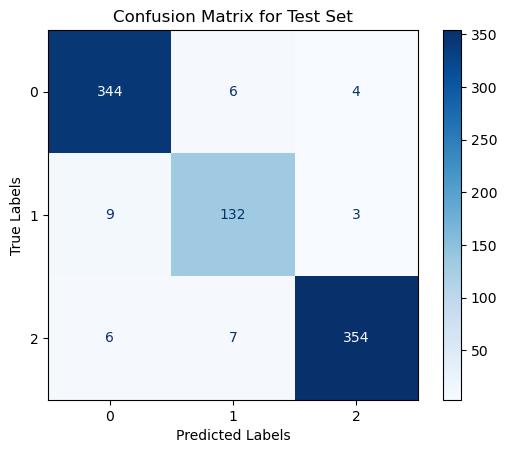

In [105]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Generate confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(np.argmax(y_test, axis=1)))
disp.plot(cmap="Blues")
disp.ax_.set_title("Confusion Matrix for Test Set")
disp.ax_.set_xlabel("Predicted Labels")
disp.ax_.set_ylabel("True Labels")
plt.show()